# A STUDY ON THE TROPOPAUSE AS CLIMATE INDICATOR

## User question: How well can we detect the seasonal and latitudinal variability of the tropopause in the GRUAN measurements?


This Notebook provides a practical introduction to the GRUAN dataset available on the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) (https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-observations-gruan-reference-network?tab=overview). Here, we present an user question of this dataset, which is addressed to calculate the tropopause altitude at three different *GCOS (Global Climate Observing System) Reference Upper Air Network (GRUAN)* stations highlighting differences related to its seasonal and latitudinal characteristics.

## Introduction
Tropopause is defined as the upper limit of the troposphere, the lower region of the atmosphere where occur the principal weather phenomena, and the stratosphere, the overlying atmospheric region characterised by high dynamic stability. It is an important boundary for studies in atmospheric sciences and it is considered as an important indicator of anthropogenic climate change [1]. Different definitions of tropopause are available, based on thermal, dynamical, and chemical characteristics of the atmosphere; in the following, the definition promulgated by the World Meteorological Organization, WMO (1957) based on temperature lapse-rate (LR) is applied [2] because of its widespread use; although some authors highlight situations where the Laps-Rate Tropopause (LRT) definition fails to reliably identify the tropopause altitude particularly in the polar regions [3]. The WMO definition also allows for identification of more than one tropopause above the primary layer; in the following, we refer to the lower tropopause detected applying the method [2] to an atmospheric profile (*first LRT*). GRUAN provides highly accurate measurements of the atmospheric profile especially for the upper troposphere and the lower stratosphere [4]; such high accuracy is necessary for understanding and monitoring tropopause characteristics. Three GRUAN station located at different latitudes are selected choosing between those available in the database, the ones with the longest data series between 2006-2020. In the following section the calculation of the LRT and the comparison between the three series are presented highlighting differences in the tropopause annual behaviour at different latitudes. Also, we assess the agreements with previous studies on the characterization of the tropopause entirely based on observational measurements [e.g. 5, 6].

### *The GCOS Reference Upper Air Network (GRUAN)*
Envisaged by the WMO in the 2007, GRUAN is a **reference** network that aims to establish 30-40 observing stations to, among others, maintain measurements over several decades to accurately quantify trends, to fully characterise the properties of the atmospheric column and to further our understanding of climate variability and change. Key points for reference quality are the traceability of the calibration and the analysis of measurement uncertainties. GRUAN responds to strict requirements as measurement accuracy and long-term stability upon observing systems; all aspects of the measurements uncertainties are determined and documented, and radiosonde data are provided with vertically resolved uncertainties (random and systematic). GRUAN uncertainty estimates are 0.15 K for night-time temperature measurements and approximately 0.6 K at 25 km during daytime [7].
One of the Scientific Imperatives of GRUAN is *"Understanding and monitoring tropopause characteristics"* [4].
At present, on the CDS, data from 18 stations in the period 2006-2020 are available (depending on the station radiosounding frequency). A new update was expected for the 2021, but it is still not available.

## Setup and retrieval
The User will be working with data in csv format. To best handle this data, libraries for working with multidimensional arrays, in particular Xarray, will be used. The User will also need libraries for plotting and viewing data, in this case Matplotlib, and for statistics Scipy.



_Import CDSAPI credential_

In [2]:
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/ciardini_virginia/.cdsapirc")

_Import packages_

In [3]:
import calendar
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import statsmodels.tsa.seasonal
import xarray as xr
from c3s_eqc_automatic_quality_control import download
from scipy import stats

plt.style.use("seaborn-v0_8-notebook")

_Define Parameters_

Time range of data series can be set by the User; different stations can be selected by means of Station acronyms (list of GRUAN station acronyms, locations, geographical coordinates and WMO n. are reported in the Product User Guide and Specification for GRUAN Temperature, Relative Humidity and Wind profiles available at https://datastore.copernicus-climate.eu/documents/in-situ/PUG_GRUAN-1.pdf) 

In [4]:
# Time period
start = "2006-05"
stop = "2020-03"

# Stations
stations = ["TEN", "LIN", "NYA"]  # Use None to analyse all stations

# Directory for csv files
csv_dir = "./csv_files"

_Define request_

In [5]:
collection_id = "insitu-observations-gruan-reference-network"
request = {
    "format": "csv-lev.zip",
    "variable": ["air_temperature", "altitude"],
}
requests = download.update_request_date(request, start=start, stop=stop)

_Functions to cache_

In [6]:
def calculate_tropopause(ds):
    attrs = {"long_name": "WMO Lapse-Rate Tropopause", "units": "km"}

    # sort and drop
    ds = ds.swap_dims(index="altitude").drop("index").sortby("altitude")
    ds = (
        ds.where(ds["altitude"].notnull())
        .dropna("altitude", how="any")
        .drop_duplicates("altitude")
    )

    # convert units
    ds["altitude"] = ds["altitude"] * 1.0e-3
    ds["air_pressure"] = ds["air_pressure"] * 1.0e-2

    if not ds.sizes["altitude"] or (ds["altitude"][-1] - ds["altitude"][0]) < 2:
        # Column must be at least 2km
        return xr.DataArray(None, attrs=attrs)

    # interpolate
    interp_altitude = np.arange(0.1, 40.1, 0.1)
    temp = ds["air_temperature"].interp(altitude=interp_altitude, method="cubic")
    temp = temp.assign_coords(
        air_pressure=10 ** np.log10(ds["air_pressure"]).interp(altitude=interp_altitude)
    )
    temp = temp.dropna("altitude")
    if not temp.sizes["altitude"]:
        return xr.DataArray(None, attrs=attrs)

    # compute lapse rate
    diff_kwargs = {"dim": "altitude", "label": "lower"}
    lapse_rate = -temp.diff(**diff_kwargs) / temp["altitude"].diff(**diff_kwargs)
    lapse_rate = lapse_rate.sel(altitude=slice(None, lapse_rate["altitude"].max() - 2))

    # mask and loop over valid lapse rates
    mask = (lapse_rate <= 2) & (lapse_rate["air_pressure"] <= 500)
    valid_altitude = lapse_rate["altitude"].where(mask.compute(), drop=True)
    for bottom in valid_altitude:
        temp_bottom = temp.sel(altitude=bottom)
        temp_above = temp.sel(altitude=slice(bottom, bottom + 2)).drop_sel(
            altitude=bottom
        )
        lapse_rate = (temp_bottom - temp_above) / (
            temp_above["altitude"] - temp_bottom["altitude"]
        )
        if (lapse_rate <= 2).all():
            return xr.DataArray(float(bottom.values), attrs=attrs)
    return xr.DataArray(None, attrs=attrs)


def compute_tropopause_altitude(ds):
    dataarrays = []
    for report_id, ds_id in ds.groupby(ds["report_id"]):
        coords = {"report_id": ("time", [report_id])}
        for var, da_coord in ds_id.data_vars.items():
            unique = set(da_coord.values)
            if len(unique) == 1:
                coords[var] = ("time", list(unique))
        da = calculate_tropopause(ds_id)
        dataarrays.append(da.expand_dims("time").assign_coords(coords))
    da = xr.concat(dataarrays, "time")
    da = da.assign_coords(time=pd.to_datetime(da["report_timestamp"]).tz_localize(None))
    return da.sortby("time").to_dataset(name="tropopause")

_Download and compute tropopause_

In [7]:
ds = download.download_and_transform(
    collection_id,
    requests,
    chunks={"year": 1, "month": 1},
    transform_func=compute_tropopause_altitude,
).compute()

if stations is not None:
    ds = ds.where(ds["station_name"].isin(stations).compute(), drop=True)
csv_dir_path = pathlib.Path(csv_dir)
csv_dir_path.mkdir(exist_ok=True)
ds.to_pandas().to_csv(csv_dir_path / "ds_data.csv")

100%|██████████| 167/167 [00:20<00:00,  8.33it/s]


## Results and discussion

To investigate tropopause characteristics at three different latitudes we considered and discussed as follow the interannual variability and the mean annual cycle; further by applying a classical decomposition, assuming (reasonably) that the seasonal component repeats from year-to-year, an attempt to estimate the trend-cycle of the LRT was carried out. The station of Ny-Ålesund (NYA, 78.92°N,11.93°E), Lindemberg (LIN, 52.21°N, 14.12°E) and Tenerife (TEN, 28.32°N, 16.38°W) have been selected taking into account stations and data availability [8] as representative of the Northern Hemisphere polar, mid-latitude and sub-tropical stations.

### _Lapse Rate Tropopause time series (monthly values) and its annual cycle_

The inter-annual variability of the first LRT shows the typical behaviour with higher (lower) values at lower (higher) latitude. Amplitude of the LRT is more pronounced at lower latitude (TEN) where mothly mean values range between 16.7 km and 9.9 km while for LIN and NYA, located at mid-latitude and in the Arctic region respectively, LRT varies from 12.4 and 9.0 km for the former and from 11.0 and 7.6 km for the latter (Figure 1). 
The annual cycle of mean LRT is calculated from data available on CDS from 2006 to 2020 for the three stations (Figure 2). Climatological statistics of the first LRT based on a long-term series of radiosoundings from the IGRA network show that the height of the first tropopause decreases from 16.2 km near the equator to 8.5 km over the polar regions [9].The mean annual cycle is more pronounced in the subtropics (TEN, in green), following the typical cycle of the incoming radiation (maximum in summer and minimum in winter), with the amplitude exceeds 2 km while in the artic region (NYA, in orange) the mean annual cycle seems to show a two-waves pattern with maxima in summer and in winter and minima in spring and fall. At mid-latitude (LIN, in blue), the cycle is less pronounced probably due to the shift in phase from mid to high latitude [5]. Results agree with those found by [5] where latitudinal and longitudinal tropopause characteristics are investigated. Nevertheless, as stated before, some authors highlight the possible fails of the LRT method in identifying the tropopause during winter and spring in the polar region [3]; as consequence, further analysis are needed to strengthen the presented results.

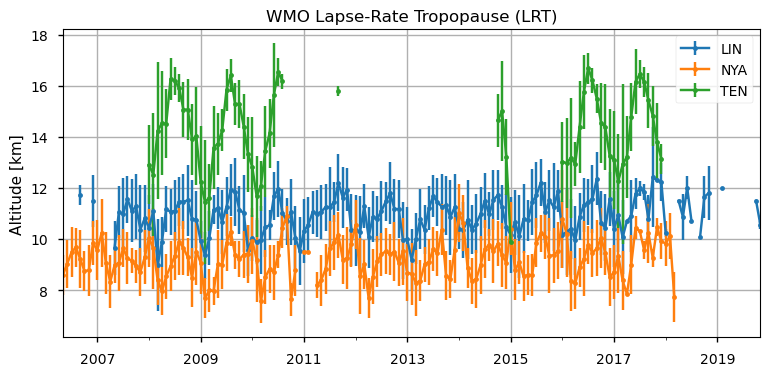

In [8]:
fig, ax = plt.subplots(figsize=[9, 4])
for station, da in ds["tropopause"].groupby("station_name"):
    da_resampled = da.resample(time="MS")
    df_mean = da_resampled.mean().to_pandas()
    df_std = da_resampled.std().to_pandas()
    df_mean.plot(yerr=df_std, marker=".", label=station)
    df_mean.to_csv(csv_dir_path / f"monthly_mean_lrt_{station.lower()}.csv")
    df_std.to_csv(csv_dir_path / f"monthly_lrt_std_{station.lower()}.csv")
ax.set_title(f"{da.attrs['long_name']} (LRT)")
ax.set_xlabel("")
ax.set_ylabel(f"Altitude [{da.attrs['units']}]")
ax.grid()
_ = ax.legend()

**Figure 1**. Monthly mean and standard deviation of the LRT for the arctic (NYA, in orange), mid-latitude (LIN, in blue) and sub-tropical (TEN, in green) stations.

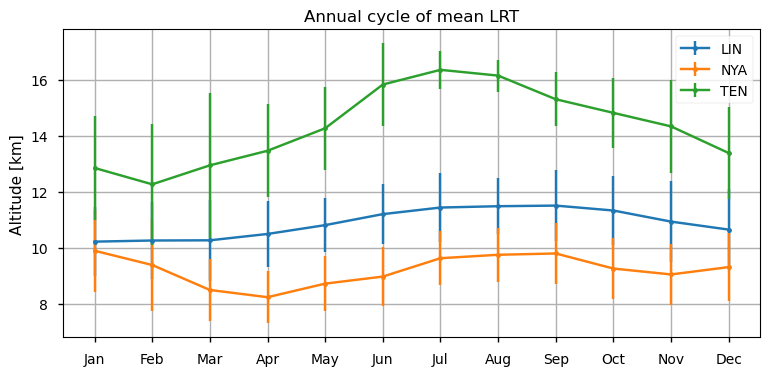

In [9]:
fig, ax = plt.subplots(figsize=[9, 4])
for station, da in ds["tropopause"].groupby("station_name"):
    grouped = da.groupby("time.month")
    df_mean = grouped.mean().to_pandas()
    df_std = grouped.std().to_pandas()
    df_mean.plot(yerr=df_std, marker=".", label=station)
    ax.set_xticks(range(1, 13), calendar.month_abbr[1:13])
    ax.set_xlabel("")
    ax.set_ylabel(f"Altitude [{da.attrs['units']}]")
    ax.set_title("Annual cycle of mean LRT")
    ax.grid()
    ax.legend()

**Figure 2.** Annual cycle of mean LRT and standard deviation for the arctic (NYA, in orange), mid-latitude (LIN, in blue) and sub-tropical (TEN, in green) stations. 

### *Trend and Seasonality of LRT*
In the follow, an attempt to separate out the time series of the monthly mean LRT into intra- and inter-annual components is carried out; only LIN and NYA are considered, excluding TEN from the analysis due to its gaps in data between mid-2010 and 2016. Then, a linear least-squares regression to the inter-annual component of the series is applied to find out the presence of a trend.
Time series of the deseasonalized monthly means of the LRT for LIN and NYA are shown in Figure 3 highlighting its inter-annual variability. The trend analysis (Figure 3), indicate that the LRT rise both in LIN and NYA during the study period. 
Other authors [6] report that in the NH, since 2000 tropopause altitude has risen mainly due to the warming of the troposphere. A fine-scale analysis computed on two sites with different climate conditions (mid-latitude and arctic) [10] shows significant positive trends in the tropopause heights with rates of increase of 23.7 ± 6.5 m yr<sup>-1</sup> at the mid-latitude site and 28.0 ± 4.0 m yr<sup>-1</sup> at the arctic site during an 18-year study period. Our preliminary results confirm the LRT increase in the decade in the two stations considered, even if at a higher rate (54 ± 7.2 m yr<sup>-1</sup> at LIN; 30 ± 7.2 m yr<sup>-1</sup> at NYA). Several factors may justify these differences such as, the wider (in time and space) dataset used in [6] and the different time periods considered [10].

LIN:
         Equation: +0.0045x -0.3875
              R^2: 0.59
    p-value (95%): < 0.001
            slope: +0.0045 ± 0.0006
        intercept: -0.3875 ± 0.0556
NYA:
         Equation: +0.0025x -0.1955
              R^2: 0.37
    p-value (95%): < 0.001
            slope: +0.0025 ± 0.0006
        intercept: -0.1955 ± 0.0468


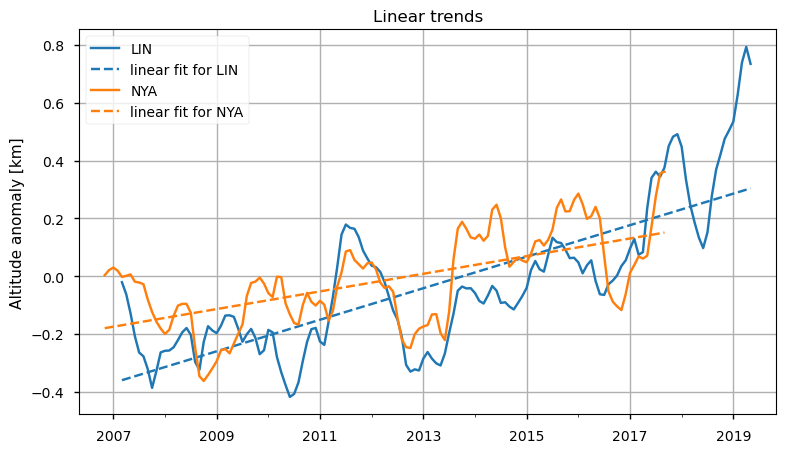

In [11]:
fig, ax = plt.subplots(figsize=[9, 5])
for i, (station, da) in enumerate(ds["tropopause"].groupby("station_name")):
    if station not in ["LIN", "NYA"]:
        continue

    # Seasonal decomposition
    df_mean = da.resample(time="MS").mean().interpolate_na("time").to_pandas()
    df_anom = df_mean - df_mean.mean()
    decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
        df_anom, model="additive"
    )
    decomposition.trend.to_csv(csv_dir_path / f"intra-annual_{station}.csv")
    decomposition.seasonal.to_csv(csv_dir_path / f"seasonal_{station}.csv")

    # Linear fit
    x_trend = np.arange(decomposition.trend.size)[~decomposition.trend.isnull()]
    y_trend = decomposition.trend.dropna()
    res = stats.linregress(x_trend, y_trend)
    fit = pd.Series(res.intercept + res.slope * x_trend, index=y_trend.index)

    # Two-sided inverse Students t-distribution
    q = 0.05 / 2
    deg_freedom = len(x_trend) - 2
    ts = scipy.stats.t.ppf(q, deg_freedom)

    # Plot
    decomposition.trend.plot(color=f"C{i}", ls="-", label=station)
    fit.plot(color=f"C{i}", ls="--", label=f"linear fit for {station}")

    # Text
    print(f"{station}:")
    pad = 17
    print(f"{'Equation':>{pad}}: {res.slope:+.4f}x {res.intercept:+.4f}")
    print(f"{'R^2':>{pad}}: {res.rvalue ** 2:.2f}")
    print(
        f"{'p-value (95%)':>{pad}}: " + "< 0.001"
        if res.pvalue < 0.001
        else f"{res.pvalue:.4f}"
    )
    print(f"{'slope':>{pad}}: {res.slope:+.4f} ± {abs(ts*res.stderr):.4f}")
    print(
        f"{'intercept':>{pad}}: {res.intercept:+.4f} ± {abs(ts*res.intercept_stderr):.4f}"
    )

# Plot settings
ax.set_title("Linear trends")
ax.set_ylabel(f"Altitude anomaly [{da.attrs['units']}]")
ax.set_xlabel("")
ax.grid()
_ = ax.legend()

**Figure 3**. Time series of the deseasonalized monthly means of the LRT for LIN (light blu) and NYA (orange); the linear fits (statistically significant at the 95%) are also reported for both stations (in blue, for LIN and in orange for NYA).

## Take-home messages

- GRUAN provides reference measurements and uncertainties and is suitable to analysed in depth tropopause characteristics, but still with some limitations related number of stations available and their spatial distribution and, in some cases, to the still limited temporal coverage.
- The first LRT has the typical behaviour with higher (lower) values at lower (higher) latitude. Amplitude of the LRT is more pronounced at lower latitude.
- The mean annual cycle is more pronounced in TEN with amplitude exceeding 2 km while at the polar station the mean annual cycle seems to show a two-waves pattern with maxima in summer and in winter and minima in spring and fall. A cycle less pronounced characterised the LIN station.
- By removing seasonality from LRT monthly mean time series and applying a linear least-squares regression, an increasing trend is revealed.
- Preliminary results presented in the Notebook are in accordance with previous findings but differences are revealed in terms of the rate of the tropopause increase, probably due to the differences in data availability (in time and space) between GRUAN radiosonde data in CDS and other data sources.
- Further analysis are needed to verify and strengthen the findings.

## References

[1]: Santer, B. D., et al. (2003b), Contributions of anthropogenic and natural forcing to recent tropopause height changes, Science, 301, 479– 483, doi:10.1126/science.1084123

[2]: WMO: Meteorology-A three-dimensional science: Second session of the commission for aerology, WMO Bull., 4, 134–138, 1957.

[3]: Tinney, E. N., C. R. Homeyer, L. Elizalde, D. F. Hurst, A. M. Thompson, R. M. Stauffer, H. Vömel, and H. B. Selkirk, 2022: A Modern Approach to a Stability-Based Definition of the Tropopause. Mon. Wea. Rev., 150, 3151–3174, https://doi.org/10.1175/MWR-D-22-0174.1.

[4]: GCOS Reference Upper-Air Network website: https://www.gruan.org/network/about-gruan.

[5]: Rieckh, T., Scherllin-Pirscher, B., Ladstädter, F., and Foelsche, U.: Characteristics of tropopause parameters as observed with GPS radio occultation, Atmos. Meas. Tech., 7, 3947–3958, https://doi.org/10.5194/amt-7-3947-2014, 2014.

[6]: Meng, L., Liu, J., Tarasick, D. W., Randel, W. J., Steiner, A. K., Wilhelmsen, H., Wang, L., & Haimberger, L. (2021). Continuous rise of the tropopause in the Northern Hemisphere over 1980-2020. Science advances, 7(45), eabi8065. https://doi.org/10.1126/sciadv.abi8065.

[7]: Dirksen, R. J., Sommer, M., Immler, F. J., Hurst, D. F., Kivi, R., and Vömel, H.: Reference quality upper-air measurements: GRUAN data processing for the Vaisala RS92 radiosonde, Atmos. Meas. Tech., 7, 4463–4490, https://doi.org/10.5194/amt-7-4463-2014, 2014.

[8]: https://datastore.copernicus-climate.eu/documents/in-situ/PUG_GRUAN-1.pdf.

[9]: Feng, S., Y. Fu, andQ. Xiao (2012), Trends in the global tropopause thickness revealed by radiosondes, Geophys.  Res.  Lett., 39, L20706, doi:10.1029/2012GL053460.

[10]: Zhang, J. Tropopause 
Characteristics Based on Long-Ter 
ARM Radiosonde Data: A Fine-Sca e
Comparison at the Extratropical  GP
Site and Arctic NSA Site. Atmosp ere
2022, 13, 965. https://do/org/
10.3390/atmos13060965